In [1]:
# import Libraries
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
#from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import math
import datetime as dt
import time

import pandas_datareader.data as data

from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Objective:

As an emerging investor, I am looking to invest in the stock market at a precise time. I am attempting to time the market in search of opportunities to buy low and sell high. However, there are many stocks to choose from. 
I need to filter through the stock to find the group of performing stocks at a specific time of the year (i.e. 31 of december).
In this project, I will attempt to use the K-means clustering algorithm to identify some performing stocks.




## Data Collection

Data pulled and stored to a database

In [2]:
# Connect to Database to retrieve data  and load the data from database to dataframe
database_name = "data/CompanyData.sqlite"
engine = create_engine(f"sqlite:///{database_name}", echo=False)
master_df = pd.read_sql_query("SELECT * FROM MasterData", engine)
master_df = master_df.dropna()
master_df.head()

,monthend_date,ticker,price,wealth_index,end_wealth_index,total_return,cash,st_debt,lt_debt,equity,...,market_cap,net_debt,net_debt_capital,enterprise_value,ev_revenue,revenue_ev,ev_ebit,ebit_ev,name,sector
0,2014-12-31,A,40.94,39.0850,36.1469,-7.517206,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.362185e+10,-555000000.0,-11.694058,1.306685e+10,3.227978,0.309791,31.185810,0.032066,Agilent Technologies Inc,Health Care
1,2015-01-31,A,37.77,36.1469,40.3961,11.755365,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.256711e+10,-555000000.0,-11.694058,1.201211e+10,2.967418,0.336993,28.668518,0.034881,Agilent Technologies Inc,Health Care
2,2015-02-28,A,42.21,40.3961,39.8624,-1.321167,2.218000e+09,0.0,1.663000e+09,5.301000e+09,...,1.404442e+10,-555000000.0,-11.694058,1.348942e+10,3.332366,0.300087,32.194315,0.031061,Agilent Technologies Inc,Health Care
3,2015-03-31,A,41.55,39.8624,39.6897,-0.433240,2.118000e+09,0.0,1.658000e+09,4.237000e+09,...,1.386108e+10,-460000000.0,-12.178978,1.340108e+10,3.295888,0.303408,32.685561,0.030595,Agilent Technologies Inc,Health Care
4,2015-04-30,A,41.37,39.6897,39.5170,-0.435125,2.118000e+09,0.0,1.658000e+09,4.237000e+09,...,1.380103e+10,-460000000.0,-12.178978,1.334103e+10,3.281120,0.304774,32.539102,0.030732,Agilent Technologies Inc,Health Care


## Aggregate the company list

In [99]:
company_cat = master_df['name'] + " - " + master_df['sector']

In [101]:
company_cat1 = company_cat.unique()
company_cat1

array(['Agilent Technologies Inc - Health Care',
       'American Airlines Group - Industrials',
       'Advance Auto Parts - Consumer Discretionary',
       'Apple Inc. - Information Technology', 'AbbVie Inc. - Health Care',
       'AmerisourceBergen Corp - Health Care',
       'ABIOMED Inc - Health Care', 'Abbott Laboratories - Health Care',
       'Accenture plc - Information Technology',
       'Adobe Systems Inc - Information Technology',
       'Analog Devices, Inc. - Information Technology',
       'Archer-Daniels-Midland Co - Consumer Staples',
       'Automatic Data Processing - Information Technology',
       'Alliance Data Systems - Information Technology',
       'Autodesk Inc. - Information Technology',
       'Ameren Corp - Utilities', 'American Electric Power - Utilities',
       'AES Corp - Utilities', 'AFLAC Inc - Financials',
       'Allergan, Plc - Health Care',
       'American International Group - Financials',
       'Apartment Investment & Management - Real Estat

In [3]:
company_name = master_df['name'].unique()
company_name


array(['Agilent Technologies Inc', 'American Airlines Group',
       'Advance Auto Parts', 'Apple Inc.', 'AbbVie Inc.',
       'AmerisourceBergen Corp', 'ABIOMED Inc', 'Abbott Laboratories',
       'Accenture plc', 'Adobe Systems Inc', 'Analog Devices, Inc.',
       'Archer-Daniels-Midland Co', 'Automatic Data Processing',
       'Alliance Data Systems', 'Autodesk Inc.', 'Ameren Corp',
       'American Electric Power', 'AES Corp', 'AFLAC Inc',
       'Allergan, Plc', 'American International Group',
       'Apartment Investment & Management', 'Assurant',
       'Arthur J. Gallagher & Co.', 'Akamai Technologies Inc',
       'Albemarle Corp', 'Align Technology', 'Alaska Air Group Inc',
       'Allstate Corp', 'Allegion', 'Alexion Pharmaceuticals',
       'Applied Materials Inc.', 'Amcor plc',
       'Advanced Micro Devices Inc', 'AMETEK Inc.',
       'Affiliated Managers Group Inc', 'Amgen Inc.',
       'Ameriprise Financial', 'American Tower Corp.', 'Amazon.com Inc.',
       'Arista Netw

In [4]:
unique_tickers = master_df['ticker'].unique()
unique_tickers


array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN',
       'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES',
       'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN',
       'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMG',
       'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS',
       'APA', 'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATO', 'ATVI', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBT',
       'BBY', 'BDX', 'BEN', 'BHGE', 'BIIB', 'BK', 'BKNG', 'BLK', 'BLL',
       'BMY', 'BR', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB',
       'CBOE', 'CBRE', 'CBS', 'CCI', 'CCL', 'CDNS', 'CE', 'CELG', 'CERN',
       'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX',
       'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF',
       'COG', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CPRI', 'CPRT', 'CRM',
       'CSCO', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS'

In [103]:
company_cat1
companies1 = dict(zip(company_cat1, unique_tickers))
companies1

{'Agilent Technologies Inc - Health Care': 'A',
 'American Airlines Group - Industrials': 'AAL',
 'Advance Auto Parts - Consumer Discretionary': 'AAP',
 'Apple Inc. - Information Technology': 'AAPL',
 'AbbVie Inc. - Health Care': 'ABBV',
 'AmerisourceBergen Corp - Health Care': 'ABC',
 'ABIOMED Inc - Health Care': 'ABMD',
 'Abbott Laboratories - Health Care': 'ABT',
 'Accenture plc - Information Technology': 'ACN',
 'Adobe Systems Inc - Information Technology': 'ADBE',
 'Analog Devices, Inc. - Information Technology': 'ADI',
 'Archer-Daniels-Midland Co - Consumer Staples': 'ADM',
 'Automatic Data Processing - Information Technology': 'ADP',
 'Alliance Data Systems - Information Technology': 'ADS',
 'Autodesk Inc. - Information Technology': 'ADSK',
 'Ameren Corp - Utilities': 'AEE',
 'American Electric Power - Utilities': 'AEP',
 'AES Corp - Utilities': 'AES',
 'AFLAC Inc - Financials': 'AFL',
 'Allergan, Plc - Health Care': 'AGN',
 'American International Group - Financials': 'AIG',
 '

In [89]:
# Combine company and tickers to form a dictionary
companies = dict(zip(company_name, unique_tickers))
companies

{'Agilent Technologies Inc': 'A',
 'American Airlines Group': 'AAL',
 'Advance Auto Parts': 'AAP',
 'Apple Inc.': 'AAPL',
 'AbbVie Inc.': 'ABBV',
 'AmerisourceBergen Corp': 'ABC',
 'ABIOMED Inc': 'ABMD',
 'Abbott Laboratories': 'ABT',
 'Accenture plc': 'ACN',
 'Adobe Systems Inc': 'ADBE',
 'Analog Devices, Inc.': 'ADI',
 'Archer-Daniels-Midland Co': 'ADM',
 'Automatic Data Processing': 'ADP',
 'Alliance Data Systems': 'ADS',
 'Autodesk Inc.': 'ADSK',
 'Ameren Corp': 'AEE',
 'American Electric Power': 'AEP',
 'AES Corp': 'AES',
 'AFLAC Inc': 'AFL',
 'Allergan, Plc': 'AGN',
 'American International Group': 'AIG',
 'Apartment Investment & Management': 'AIV',
 'Assurant': 'AIZ',
 'Arthur J. Gallagher & Co.': 'AJG',
 'Akamai Technologies Inc': 'AKAM',
 'Albemarle Corp': 'ALB',
 'Align Technology': 'ALGN',
 'Alaska Air Group Inc': 'ALK',
 'Allstate Corp': 'ALL',
 'Allegion': 'ALLE',
 'Alexion Pharmaceuticals': 'ALXN',
 'Applied Materials Inc.': 'AMAT',
 'Amcor plc': 'AMCR',
 'Advanced Micro 

In [6]:
# # Delete the follower tickers, due to zero value
# del companies['Baker Hughes, a GE Company']
# del companies['Fox Corporation Class B']
# del companies['Total System Services']

# companies

## Extracting Data and Transforming Data

In [7]:
# Stock Market Data from yahoo finance, can also extract finacial data from 'quandl' (data_source = 'quandl' + api)
# Use 6 features of stock market: 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'
# 'High' - Highest price during the day
# 'Low' - Lowest price during the day
# 'Open' - Opening price during the day
# 'Close' - Closing price during the day
# 'Volume' - Number of stock shares traded during the day
# 'Adj Close' - Closing price after adjustments for all applicable splits and dividend distributions

data_source = 'yahoo' 

start_date = '2017-01-01' 
end_date = '2018-12-31'

# Extract stock data using dataReader or data.get_data_yahoo('companies_name', start= '2019-09-27', end='2019-11-30')
df = data.DataReader(list(companies.values()), data_source, start_date, end_date)
df

Attributes  Adj Close                                                \
Symbols             A        AAL         AAP        AAPL       ABBV   
Date                                                                  
2017-01-03  45.265160  44.906567  169.691284  110.953873  54.853149   
2017-01-04  45.859093  45.294525  171.083817  110.829704  55.626598   
2017-01-05  45.313847  44.508907  170.964462  111.393303  56.048473   
2017-01-06  46.725651  44.819275  168.726456  112.635139  56.066063   
2017-01-09  46.871700  45.663097  168.626968  113.666824  56.435196   
2017-01-10  46.832748  47.020958  169.014877  113.781464  56.312145   
2017-01-11  47.952446  47.176144  172.506210  114.392822  54.279125   
2017-01-12  47.241684  46.652393  173.540665  113.915184  54.403416   
2017-01-13  47.407211  46.215939  173.858963  113.714584  55.033745   
2017-01-17  47.046955  45.343025  172.078506  114.631653  54.918331   
2017-01-18  46.978802  46.206253  173.053284  114.622086  54.740765   
2017-01-19  46.384865  45.837677  170.805313  114.421486  54.492195   
2017-01-20  46.365391  46.555408  170.586502  114.631653  54.288010   
2017-01-23  46.141460  45.527306  166.886307  114.708061  54.119328   
2017-01-24  46.102509  46.109257  167.393570  114.602982  53.781971   
2017-01-25  47.134575  46.468109  166.607803  116.427536  54.492195   
2017-01-26  46.900902  48.097553  164.618454  116.484856  54.394535   
2017-01-27  47.368263  45.537010  163.494476  116.494415  53.267048   
2017-01-30  46.414070  43.548706  163.753098  116.188705  53.648800   
2017-01-31  47.679825  42.918262  163.365173  115.921227  54.252491   
2017-02-01  47.962193  42.724277  159.734573  122.990189  54.057178   
2017-02-02  47.611668  42.685486  161.475296  122.780045  54.057178   
2017-02-03  48.079033  42.869774  161.883087  123.305435  53.861858   
2017-02-06  47.971924  43.936661  159.416321  124.461311  53.844109   
2017-02-07  48.332180  43.810570  158.332092  125.645805  53.764210   
2017-02-08  48.614529  43.703884  161.863205  126.133018  53.728699   
2017-02-09  49.140312  45.006447  163.952026  127.044449  54.012791   
2017-02-10  49.033207  45.152260  163.176193  126.756615  53.639923   
2017-02-13  49.188992  46.085442  161.525040  127.879105  53.719822   
2017-02-14  49.062412  45.268906  163.494476  129.538910  53.995033   
...               ...        ...         ...         ...        ...   
2018-11-15  64.013916  37.355724  178.708313  188.576630  85.318542   
2018-11-16  64.280968  36.298862  178.868011  190.665237  86.634193   
2018-11-19  61.926933  35.380276  177.410782  183.108780  84.693848   
2018-11-20  66.783363  35.153103  171.202652  174.360245  83.378189   
2018-11-21  66.981186  35.864258  174.336670  174.163193  81.541969   
2018-11-23  67.465836  37.484127  176.901749  169.739655  81.049774   
2018-11-26  68.494492  37.632282  177.380844  172.035172  81.627144   
2018-11-27  68.603302  37.819954  178.927887  171.660797  82.990128   
2018-11-28  70.700172  38.461971  178.608475  178.261627  84.182724   
2018-11-29  70.789185  37.948360  177.330933  176.892197  85.100853   
2018-11-30  71.560669  39.666996  177.370865  175.936554  89.227631   
2018-12-03  73.855354  39.163261  177.550537  182.084183  88.650269   
2018-12-04  72.114571  36.239594  177.849945  174.074539  85.706612   
2018-12-06  71.125473  36.486523  175.424576  172.133682  85.498383   
2018-12-07  69.483574  33.157898  167.270172  165.995926  82.308632   
2018-12-10  69.819862  33.424583  165.852875  167.089478  82.923874   
2018-12-11  70.274857  33.681389  165.483582  166.133850  83.453911   
2018-12-12  70.967216  33.928322  166.661331  166.596878  83.860916   
2018-12-13  70.363869  32.061523  165.972641  168.419479  83.018524   
2018-12-14  68.603302  32.012135  163.467438  163.030457  81.030846   
2018-12-17  67.109772  31.646681  158.536880  161.513260  80.387222   
2018-12-18  67.248238  33.128265  157.938034  163.611740  79.109421   
2018-12-19  66.100906  3

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2017-01-03 to 2018-12-31
Columns: 2952 entries, (Adj Close, A) to (Volume, ZTS)
dtypes: float64(2952)
memory usage: 11.3 MB


In [9]:
list(df)

[('Adj Close', 'A'),
 ('Adj Close', 'AAL'),
 ('Adj Close', 'AAP'),
 ('Adj Close', 'AAPL'),
 ('Adj Close', 'ABBV'),
 ('Adj Close', 'ABC'),
 ('Adj Close', 'ABMD'),
 ('Adj Close', 'ABT'),
 ('Adj Close', 'ACN'),
 ('Adj Close', 'ADBE'),
 ('Adj Close', 'ADI'),
 ('Adj Close', 'ADM'),
 ('Adj Close', 'ADP'),
 ('Adj Close', 'ADS'),
 ('Adj Close', 'ADSK'),
 ('Adj Close', 'AEE'),
 ('Adj Close', 'AEP'),
 ('Adj Close', 'AES'),
 ('Adj Close', 'AFL'),
 ('Adj Close', 'AGN'),
 ('Adj Close', 'AIG'),
 ('Adj Close', 'AIV'),
 ('Adj Close', 'AIZ'),
 ('Adj Close', 'AJG'),
 ('Adj Close', 'AKAM'),
 ('Adj Close', 'ALB'),
 ('Adj Close', 'ALGN'),
 ('Adj Close', 'ALK'),
 ('Adj Close', 'ALL'),
 ('Adj Close', 'ALLE'),
 ('Adj Close', 'ALXN'),
 ('Adj Close', 'AMAT'),
 ('Adj Close', 'AMCR'),
 ('Adj Close', 'AMD'),
 ('Adj Close', 'AME'),
 ('Adj Close', 'AMG'),
 ('Adj Close', 'AMGN'),
 ('Adj Close', 'AMP'),
 ('Adj Close', 'AMT'),
 ('Adj Close', 'AMZN'),
 ('Adj Close', 'ANET'),
 ('Adj Close', 'ANSS'),
 ('Adj Close', 'ANTM'

In [95]:
df
# sector = master_df['sector']
# #df['Sector'] = sector
# sector

Attributes  Adj Close                                                \
Symbols             A        AAL         AAP        AAPL       ABBV   
Date                                                                  
2017-01-03  45.265160  44.906567  169.691284  110.953873  54.853149   
2017-01-04  45.859093  45.294525  171.083817  110.829704  55.626598   
2017-01-05  45.313847  44.508907  170.964462  111.393303  56.048473   
2017-01-06  46.725651  44.819275  168.726456  112.635139  56.066063   
2017-01-09  46.871700  45.663097  168.626968  113.666824  56.435196   
2017-01-10  46.832748  47.020958  169.014877  113.781464  56.312145   
2017-01-11  47.952446  47.176144  172.506210  114.392822  54.279125   
2017-01-12  47.241684  46.652393  173.540665  113.915184  54.403416   
2017-01-13  47.407211  46.215939  173.858963  113.714584  55.033745   
2017-01-17  47.046955  45.343025  172.078506  114.631653  54.918331   
2017-01-18  46.978802  46.206253  173.053284  114.622086  54.740765   
2017-01-19  46.384865  45.837677  170.805313  114.421486  54.492195   
2017-01-20  46.365391  46.555408  170.586502  114.631653  54.288010   
2017-01-23  46.141460  45.527306  166.886307  114.708061  54.119328   
2017-01-24  46.102509  46.109257  167.393570  114.602982  53.781971   
2017-01-25  47.134575  46.468109  166.607803  116.427536  54.492195   
2017-01-26  46.900902  48.097553  164.618454  116.484856  54.394535   
2017-01-27  47.368263  45.537010  163.494476  116.494415  53.267048   
2017-01-30  46.414070  43.548706  163.753098  116.188705  53.648800   
2017-01-31  47.679825  42.918262  163.365173  115.921227  54.252491   
2017-02-01  47.962193  42.724277  159.734573  122.990189  54.057178   
2017-02-02  47.611668  42.685486  161.475296  122.780045  54.057178   
2017-02-03  48.079033  42.869774  161.883087  123.305435  53.861858   
2017-02-06  47.971924  43.936661  159.416321  124.461311  53.844109   
2017-02-07  48.332180  43.810570  158.332092  125.645805  53.764210   
2017-02-08  48.614529  43.703884  161.863205  126.133018  53.728699   
2017-02-09  49.140312  45.006447  163.952026  127.044449  54.012791   
2017-02-10  49.033207  45.152260  163.176193  126.756615  53.639923   
2017-02-13  49.188992  46.085442  161.525040  127.879105  53.719822   
2017-02-14  49.062412  45.268906  163.494476  129.538910  53.995033   
...               ...        ...         ...         ...        ...   
2018-11-15  64.013916  37.355724  178.708313  188.576630  85.318542   
2018-11-16  64.280968  36.298862  178.868011  190.665237  86.634193   
2018-11-19  61.926933  35.380276  177.410782  183.108780  84.693848   
2018-11-20  66.783363  35.153103  171.202652  174.360245  83.378189   
2018-11-21  66.981186  35.864258  174.336670  174.163193  81.541969   
2018-11-23  67.465836  37.484127  176.901749  169.739655  81.049774   
2018-11-26  68.494492  37.632282  177.380844  172.035172  81.627144   
2018-11-27  68.603302  37.819954  178.927887  171.660797  82.990128   
2018-11-28  70.700172  38.461971  178.608475  178.261627  84.182724   
2018-11-29  70.789185  37.948360  177.330933  176.892197  85.100853   
2018-11-30  71.560669  39.666996  177.370865  175.936554  89.227631   
2018-12-03  73.855354  39.163261  177.550537  182.084183  88.650269   
2018-12-04  72.114571  36.239594  177.849945  174.074539  85.706612   
2018-12-06  71.125473  36.486523  175.424576  172.133682  85.498383   
2018-12-07  69.483574  33.157898  167.270172  165.995926  82.308632   
2018-12-10  69.819862  33.424583  165.852875  167.089478  82.923874   
2018-12-11  70.274857  33.681389  165.483582  166.133850  83.453911   
2018-12-12  70.967216  33.928322  166.661331  166.596878  83.860916   
2018-12-13  70.363869  32.061523  165.972641  168.419479  83.018524   
2018-12-14  68.603302  32.012135  163.467438  163.030457  81.030846   
2018-12-17  67.109772  31.646681  158.536880  161.513260  80.387222   
2018-12-18  67.248238  33.128265  157.938034  163.611740  79.109421   
2018-12-19  66.100906  3

In [25]:
# Drop the following tickers dues to null values

df = df.drop(columns=[('Adj Close', 'BHGE'),('Adj Close', 'FOX'), ('Adj Close', 'TSS'),('Close', 'BHGE'), ('Close', 'FOX'), ('Close', 'TSS'),('High', 'BHGE'),('High', 'FOX'),('High', 'TSS'),('Low', 'FOX'),('Low', 'TSS'),('Open', 'BHGE'), ('Open', 'FOX'), ('Open', 'TSS'), ('Volume', 'BHGE'), ('Volume', 'FOX'), ('Volume', 'TSS') ])
df


Attributes  Adj Close                                                \
Symbols             A        AAL         AAP        AAPL       ABBV   
Date                                                                  
2017-01-03  45.265160  44.906567  169.691284  110.953873  54.853149   
2017-01-04  45.859093  45.294525  171.083817  110.829704  55.626598   
2017-01-05  45.313847  44.508907  170.964462  111.393303  56.048473   
2017-01-06  46.725651  44.819275  168.726456  112.635139  56.066063   
2017-01-09  46.871700  45.663097  168.626968  113.666824  56.435196   
2017-01-10  46.832748  47.020958  169.014877  113.781464  56.312145   
2017-01-11  47.952446  47.176144  172.506210  114.392822  54.279125   
2017-01-12  47.241684  46.652393  173.540665  113.915184  54.403416   
2017-01-13  47.407211  46.215939  173.858963  113.714584  55.033745   
2017-01-17  47.046955  45.343025  172.078506  114.631653  54.918331   
2017-01-18  46.978802  46.206253  173.053284  114.622086  54.740765   
2017-01-19  46.384865  45.837677  170.805313  114.421486  54.492195   
2017-01-20  46.365391  46.555408  170.586502  114.631653  54.288010   
2017-01-23  46.141460  45.527306  166.886307  114.708061  54.119328   
2017-01-24  46.102509  46.109257  167.393570  114.602982  53.781971   
2017-01-25  47.134575  46.468109  166.607803  116.427536  54.492195   
2017-01-26  46.900902  48.097553  164.618454  116.484856  54.394535   
2017-01-27  47.368263  45.537010  163.494476  116.494415  53.267048   
2017-01-30  46.414070  43.548706  163.753098  116.188705  53.648800   
2017-01-31  47.679825  42.918262  163.365173  115.921227  54.252491   
2017-02-01  47.962193  42.724277  159.734573  122.990189  54.057178   
2017-02-02  47.611668  42.685486  161.475296  122.780045  54.057178   
2017-02-03  48.079033  42.869774  161.883087  123.305435  53.861858   
2017-02-06  47.971924  43.936661  159.416321  124.461311  53.844109   
2017-02-07  48.332180  43.810570  158.332092  125.645805  53.764210   
2017-02-08  48.614529  43.703884  161.863205  126.133018  53.728699   
2017-02-09  49.140312  45.006447  163.952026  127.044449  54.012791   
2017-02-10  49.033207  45.152260  163.176193  126.756615  53.639923   
2017-02-13  49.188992  46.085442  161.525040  127.879105  53.719822   
2017-02-14  49.062412  45.268906  163.494476  129.538910  53.995033   
...               ...        ...         ...         ...        ...   
2018-11-15  64.013916  37.355724  178.708313  188.576630  85.318542   
2018-11-16  64.280968  36.298862  178.868011  190.665237  86.634193   
2018-11-19  61.926933  35.380276  177.410782  183.108780  84.693848   
2018-11-20  66.783363  35.153103  171.202652  174.360245  83.378189   
2018-11-21  66.981186  35.864258  174.336670  174.163193  81.541969   
2018-11-23  67.465836  37.484127  176.901749  169.739655  81.049774   
2018-11-26  68.494492  37.632282  177.380844  172.035172  81.627144   
2018-11-27  68.603302  37.819954  178.927887  171.660797  82.990128   
2018-11-28  70.700172  38.461971  178.608475  178.261627  84.182724   
2018-11-29  70.789185  37.948360  177.330933  176.892197  85.100853   
2018-11-30  71.560669  39.666996  177.370865  175.936554  89.227631   
2018-12-03  73.855354  39.163261  177.550537  182.084183  88.650269   
2018-12-04  72.114571  36.239594  177.849945  174.074539  85.706612   
2018-12-06  71.125473  36.486523  175.424576  172.133682  85.498383   
2018-12-07  69.483574  33.157898  167.270172  165.995926  82.308632   
2018-12-10  69.819862  33.424583  165.852875  167.089478  82.923874   
2018-12-11  70.274857  33.681389  165.483582  166.133850  83.453911   
2018-12-12  70.967216  33.928322  166.661331  166.596878  83.860916   
2018-12-13  70.363869  32.061523  165.972641  168.419479  83.018524   
2018-12-14  68.603302  32.012135  163.467438  163.030457  81.030846   
2018-12-17  67.109772  31.646681  158.536880  161.513260  80.387222   
2018-12-18  67.248238  33.128265  157.938034  163.611740  79.109421   
2018-12-19  66.100906  3

In [ ]:
# Save data to csv file
# df.to_csv("data/stockdata.csv")

In [42]:
# Delete the companies with null values
del companies['Baker Hughes, a GE Company']
del companies['Fox Corporation Class B']
del companies['Total System Services']

companies

{'Agilent Technologies Inc': 'A',
 'American Airlines Group': 'AAL',
 'Advance Auto Parts': 'AAP',
 'Apple Inc.': 'AAPL',
 'AbbVie Inc.': 'ABBV',
 'AmerisourceBergen Corp': 'ABC',
 'ABIOMED Inc': 'ABMD',
 'Abbott Laboratories': 'ABT',
 'Accenture plc': 'ACN',
 'Adobe Systems Inc': 'ADBE',
 'Analog Devices, Inc.': 'ADI',
 'Archer-Daniels-Midland Co': 'ADM',
 'Automatic Data Processing': 'ADP',
 'Alliance Data Systems': 'ADS',
 'Autodesk Inc.': 'ADSK',
 'Ameren Corp': 'AEE',
 'American Electric Power': 'AEP',
 'AES Corp': 'AES',
 'AFLAC Inc': 'AFL',
 'Allergan, Plc': 'AGN',
 'American International Group': 'AIG',
 'Apartment Investment & Management': 'AIV',
 'Assurant': 'AIZ',
 'Arthur J. Gallagher & Co.': 'AJG',
 'Akamai Technologies Inc': 'AKAM',
 'Albemarle Corp': 'ALB',
 'Align Technology': 'ALGN',
 'Alaska Air Group Inc': 'ALK',
 'Allstate Corp': 'ALL',
 'Allegion': 'ALLE',
 'Alexion Pharmaceuticals': 'ALXN',
 'Applied Materials Inc.': 'AMAT',
 'Amcor plc': 'AMCR',
 'Advanced Micro 

In [107]:
# del companies1['Baker Hughes, a GE Company - Energy']
# del companies1['Fox Corporation Class B - Communication Services']
# del companies1['Total System Services - Information Technology']

#companies1

{'Agilent Technologies Inc - Health Care': 'A',
 'American Airlines Group - Industrials': 'AAL',
 'Advance Auto Parts - Consumer Discretionary': 'AAP',
 'Apple Inc. - Information Technology': 'AAPL',
 'AbbVie Inc. - Health Care': 'ABBV',
 'AmerisourceBergen Corp - Health Care': 'ABC',
 'ABIOMED Inc - Health Care': 'ABMD',
 'Abbott Laboratories - Health Care': 'ABT',
 'Accenture plc - Information Technology': 'ACN',
 'Adobe Systems Inc - Information Technology': 'ADBE',
 'Analog Devices, Inc. - Information Technology': 'ADI',
 'Archer-Daniels-Midland Co - Consumer Staples': 'ADM',
 'Automatic Data Processing - Information Technology': 'ADP',
 'Alliance Data Systems - Information Technology': 'ADS',
 'Autodesk Inc. - Information Technology': 'ADSK',
 'Ameren Corp - Utilities': 'AEE',
 'American Electric Power - Utilities': 'AEP',
 'AES Corp - Utilities': 'AES',
 'AFLAC Inc - Financials': 'AFL',
 'Allergan, Plc - Health Care': 'AGN',
 'American International Group - Financials': 'AIG',
 '

In [120]:
# df['Close'].plot(figsize=(15,5))


In [27]:
# Save a copy of the stockdata from the start_date to end_date in a cvs file
df.to_csv('data/companies_stockdata2017_2018.csv')

In [28]:
stock_data = pd.read_csv('data/companies_stockdata2017_2018.csv')  

In [30]:
# Transpose df['Open'] and df['Close'] for all stock data
stock_open = np.array(df['Open']).T 
stock_close = np.array(df['Close']).T 

In [ ]:
stock_data

In [31]:
# Daily, the difference of the opening and closing stock prices suggest to buy or to sell.
# (+ve) movement indicates buy and of course (-ve) indicates to sell.
movements = stock_close - stock_open

In [32]:
# Summation of movements (differences of the opening and closing prices) for all days
sum_of_movement = np.sum(movements,1)
sum_of_movement

array([-1.17799263e+01, -2.63799858e+01, -6.67199554e+01,  1.20899811e+01,
        1.37100677e+01,  4.45007324e+00,  5.28401031e+01,  1.94200439e+01,
        1.44300385e+01,  9.01002502e+00, -2.61003113e+00, -1.17500229e+01,
        2.71501083e+01, -1.11809998e+02,  1.05012512e+00,  9.06996536e+00,
        1.29099960e+01,  5.59990883e-01, -7.09991455e-01, -1.14529800e+02,
       -1.63499985e+01, -4.18001938e+00, -1.59300232e+01,  6.78002167e+00,
       -1.62500153e+01, -5.56099701e+01,  3.60198746e+01, -3.44299316e+01,
       -2.12001801e+00, -8.92999268e+00, -1.48749878e+02, -1.50000076e+01,
       -1.42000103e+00, -5.05001736e+00, -7.93994522e+00, -9.01802826e+01,
        4.14699249e+01, -5.86598511e+01,  2.32698669e+01, -6.16240295e+02,
        9.49485016e+00,  2.74007416e+00,  5.80599060e+01,  7.91013336e+00,
       -1.78699532e+01, -4.05000458e+01, -1.58699493e+01, -1.17000961e+01,
       -4.10297928e+01, -1.19000626e+01, -4.79974747e-01,  9.35001373e+00,
       -1.28600006e+01, -

In [78]:
# Print the sum of movement for each companyfor i in range(len(companies))
# Companies with (-ve) indicates buy and companies with (-ve) indicates sells
for i in range(len(companies)):    
 print('company:{}, Change:{}, item #: {}'.format(df['High'].columns[i],sum_of_movement[i], i))

company:A, Change:-11.779926300048828, item #: 0
company:AAL, Change:-26.379985809326172, item #: 1
company:AAP, Change:-66.71995544433594, item #: 2
company:AAPL, Change:12.089981079101562, item #: 3
company:ABBV, Change:13.710067749023438, item #: 4
company:ABC, Change:4.4500732421875, item #: 5
company:ABMD, Change:52.84010314941406, item #: 6
company:ABT, Change:19.4200439453125, item #: 7
company:ACN, Change:14.430038452148438, item #: 8
company:ADBE, Change:9.010025024414062, item #: 9
company:ADI, Change:-2.6100311279296875, item #: 10
company:ADM, Change:-11.750022888183594, item #: 11
company:ADP, Change:27.150108337402344, item #: 12
company:ADS, Change:-111.80999755859375, item #: 13
company:ADSK, Change:1.0501251220703125, item #: 14
company:AEE, Change:9.069965362548828, item #: 15
company:AEP, Change:12.909996032714844, item #: 16
company:AES, Change:0.5599908828735352, item #: 17
company:AFL, Change:-0.709991455078125, item #: 18
company:AGN, Change:-114.52980041503906, 

company:NVDA, Change:-104.02010345458984, item #: 340
company:NWL, Change:-22.160030364990234, item #: 341
company:NWS, Change:-3.15000057220459, item #: 342
company:O, Change:2.939990997314453, item #: 343
company:OKE, Change:-23.090015411376953, item #: 344
company:OMC, Change:-9.999992370605469, item #: 345
company:ORCL, Change:7.329990386962891, item #: 346
company:ORLY, Change:14.510208129882812, item #: 347
company:OXY, Change:-27.269908905029297, item #: 348
company:PAYX, Change:1.4400100708007812, item #: 349
company:PBCT, Change:-8.049997329711914, item #: 350
company:PCAR, Change:-6.499980926513672, item #: 351
company:PEG, Change:9.720039367675781, item #: 352
company:PEP, Change:7.080047607421875, item #: 353
company:PFE, Change:19.620019912719727, item #: 354
company:PFG, Change:-26.54000473022461, item #: 355
company:PG, Change:9.070030212402344, item #: 356
company:PGR, Change:5.269981384277344, item #: 357
company:PH, Change:-31.339874267578125, item #: 358
company:PHM,

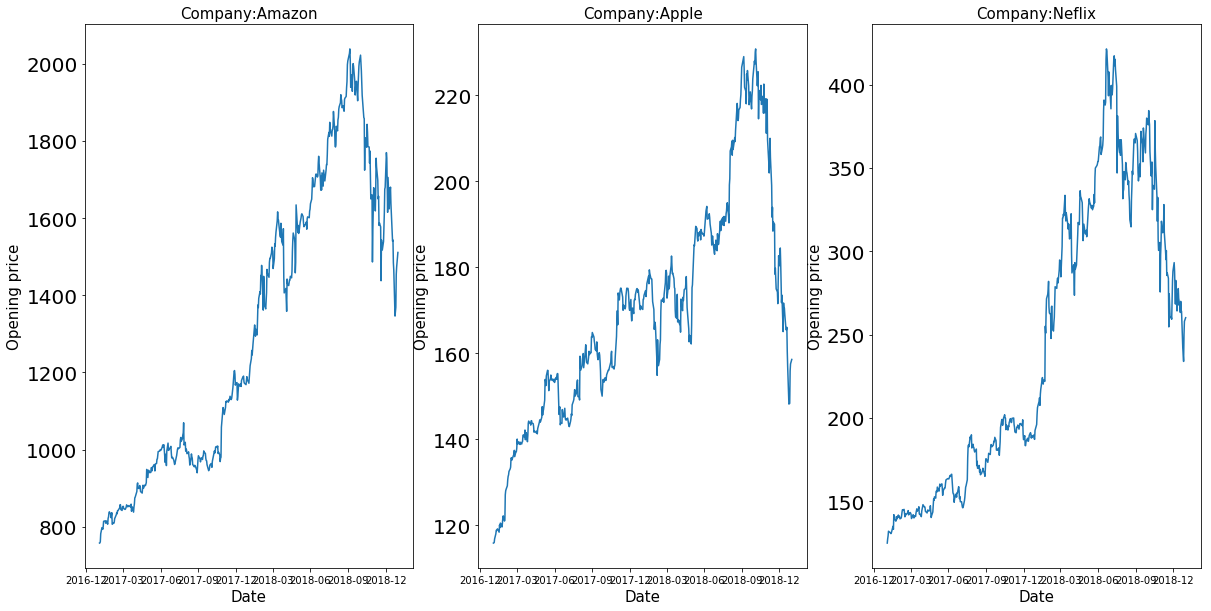

In [62]:
# Visualize the data, comparing between the companies Amazon, Apple and Netflix
plt.figure(figsize = (20,10)) 

plt.subplot(1,3,1) 
plt.title('Company:Amazon',fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Opening price',fontsize = 15)
plt.plot(df['Open']['AMZN'])

plt.subplot(1,3,2) 
plt.title('Company:Apple',fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Opening price',fontsize = 15)
plt.plot(df['Open']['AAPL'])

plt.subplot(1,3,3) 
plt.title('Company:Neflix',fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Opening price',fontsize = 15)
plt.plot(df['Open']['NFLX'])

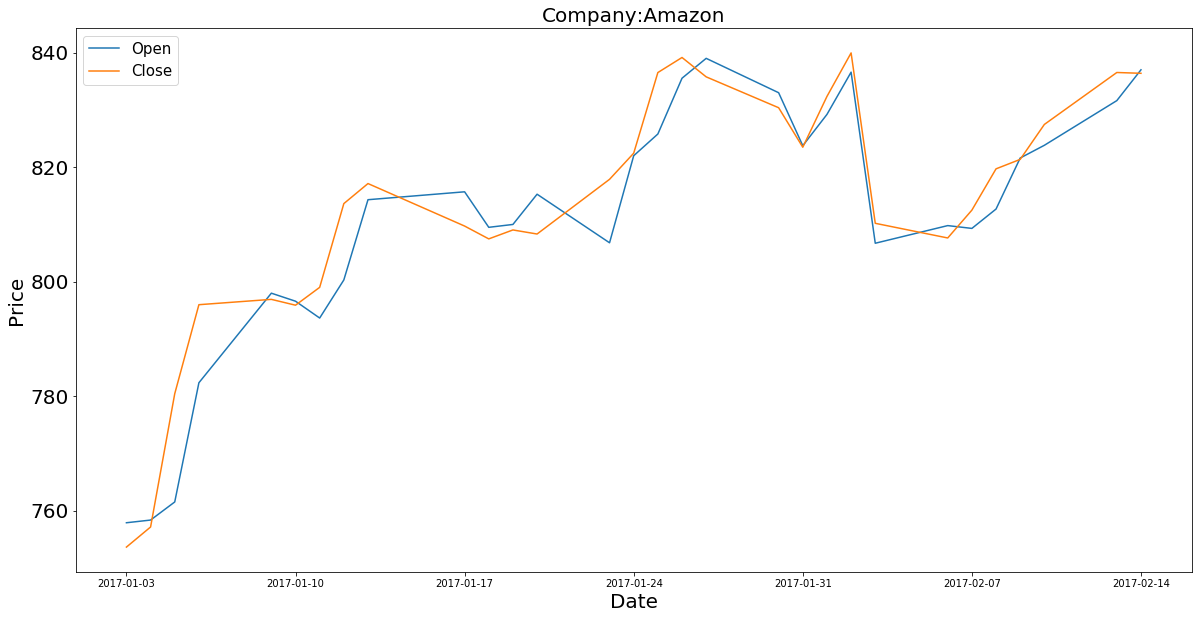

In [69]:
# Now, let's narrow down to one company Amazon, with price gain over time
# Plot the opening and closing price of Amazon
plt.figure(figsize = (20,10)) 
plt.title('Company:Amazon',fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.ylabel('Price',fontsize = 20)

# Plot opening and closing price for the first 30 days of the start date
plt.plot(df.iloc[0:30]['Open']['AMZN'],label = 'Open') 
plt.plot(df.iloc[0:30]['Close']['AMZN'],label = 'Close') 

# Set legend to upper left and increase the size of frame
plt.legend(loc='upper left', prop={'size': 15})

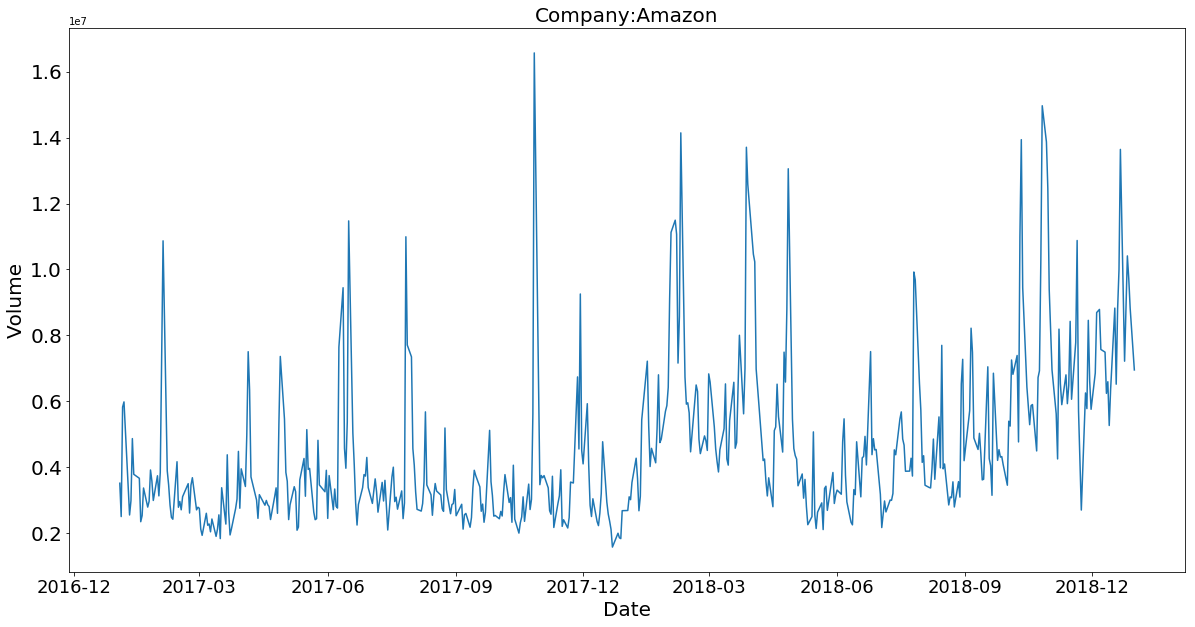

In [35]:
plt.figure(figsize = (20,10)) 
plt.title('Company:Amazon',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.ylabel('Volume',fontsize = 20)
plt.plot(df['Volume']['AMZN'],label = 'Open')

In [70]:
# Candlestick chart for the first 90 days, to predict particular market movements
fig = go.Figure(data=[go.Candlestick(x=df.index,
 open=df.iloc[0:90]['Open']['AMZN'],
 high=df.iloc[0:90]['High']['AMZN'],
 low=df.iloc[0:90]['Low']['AMZN'],
 close=df.iloc[0:90]['Close']['AMZN'])])
fig.show()

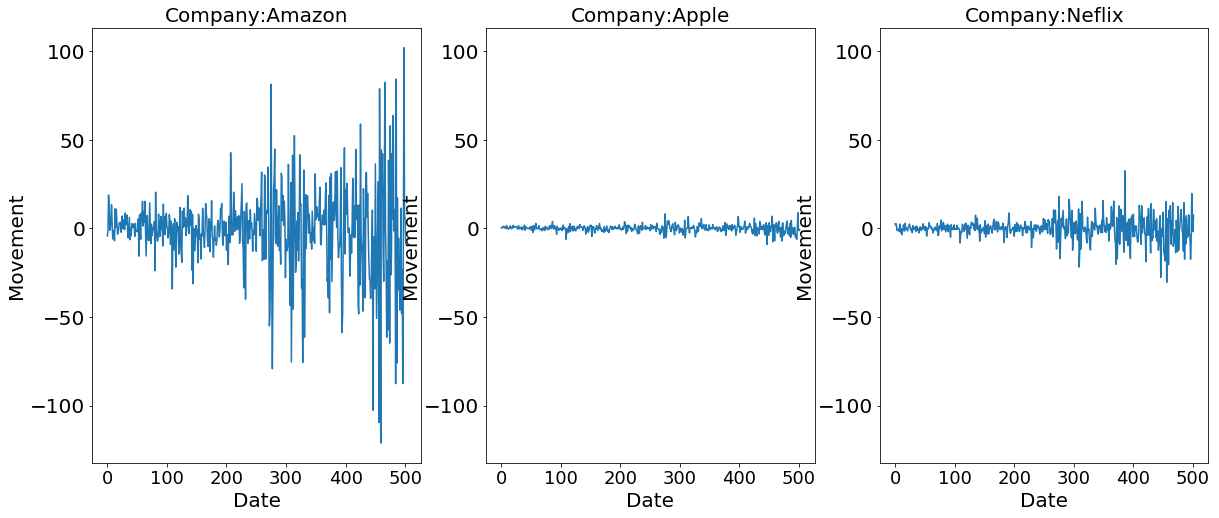

In [79]:

# Visualize the movements, comparing between the companies Amazon, Apple and Netflix
plt.figure(figsize = (20,8)) 
ax1 = plt.subplot(1,3,1)
plt.title('Company:Amazon',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.ylabel('Movement',fontsize = 20)
plt.plot(movements[39]) 

plt.subplot(1,3,2,sharey = ax1)
plt.title('Company:Apple',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.ylabel('Movement',fontsize = 20)
plt.plot(movements[3])

plt.subplot(1,3,3,sharey = ax1)
plt.title('Company:Neflix',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 20)
plt.xlabel('Date',fontsize = 20)
plt.ylabel('Movement',fontsize = 20)
plt.plot(movements[328])

In [ ]:
# In camparison of the company aove, it is fair to normalize the movement as it varies from company Amazon to Apple as well as Neflix

## Standardized the data

In [38]:
# Normalizing the data
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
norm_movements = normalizer.fit_transform(movements) # Fit and transform

## Select Algorithm - K-means Clustering

#### How K-means Clustering work

* Step 1: Determine K value by Elbow method and specify the number of clusters K
* Step 2: Randomly assign each data point to a cluster
* Step 3: Determine the cluster centroid coordinates
* Step 4: Determine the distances of each data point to the centroids and re-assign each point to the closest cluster centroid based upon minimum distance
* Step 5: Calculate cluster centroids again
* Step 6: Repeat steps 4 and 5 until we reach global optima where no improvements are possible and no switching of data points from one cluster to other.

## Find the optimum number of clusters for k-means clustering

Text(0,0.5,'Score')

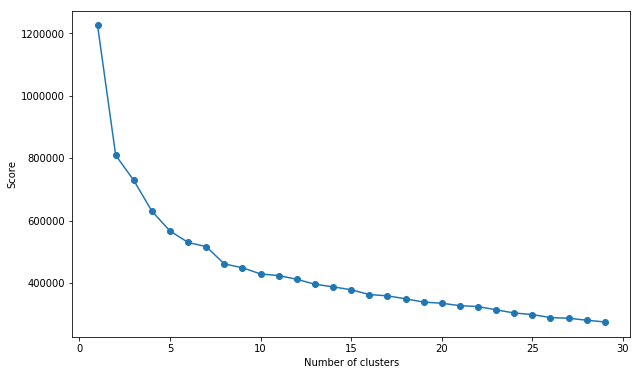

In [71]:

# Draw elbow plot and figure out the optimal value of k
# fitting multiple k-means algorithms and storing the values in an empty list

score = []

for cluster in range(1,30):

    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(movements)
    score.append(kmeans.inertia_)

# Convert results into a dataframe and plot
frame = pd.DataFrame({'Cluster':range(1,30), 'score':score})

plt.figure(figsize=(10,6))
plt.plot(frame['Cluster'], frame['score'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

In [109]:
# Ok, let see how K-Means clustering worked in grouping the stocks into their financial sectors
# Import the necessary libraries
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

# Define a normalizer
normalizer = Normalizer()

# Create Kmeans model
kmeans = KMeans(n_clusters = 11,max_iter = 1000)

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

# Fit pipeline to daily stock movements
pipeline.fit(movements)
labels = pipeline.predict(movements)

In [117]:

[key.split('-') for key in companies1.keys()]


[['Agilent Technologies Inc ', ' Health Care'],
 ['American Airlines Group ', ' Industrials'],
 ['Advance Auto Parts ', ' Consumer Discretionary'],
 ['Apple Inc. ', ' Information Technology'],
 ['AbbVie Inc. ', ' Health Care'],
 ['AmerisourceBergen Corp ', ' Health Care'],
 ['ABIOMED Inc ', ' Health Care'],
 ['Abbott Laboratories ', ' Health Care'],
 ['Accenture plc ', ' Information Technology'],
 ['Adobe Systems Inc ', ' Information Technology'],
 ['Analog Devices, Inc. ', ' Information Technology'],
 ['Archer', 'Daniels', 'Midland Co ', ' Consumer Staples'],
 ['Automatic Data Processing ', ' Information Technology'],
 ['Alliance Data Systems ', ' Information Technology'],
 ['Autodesk Inc. ', ' Information Technology'],
 ['Ameren Corp ', ' Utilities'],
 ['American Electric Power ', ' Utilities'],
 ['AES Corp ', ' Utilities'],
 ['AFLAC Inc ', ' Financials'],
 ['Allergan, Plc ', ' Health Care'],
 ['American International Group ', ' Financials'],
 ['Apartment Investment & Management ', '

In [110]:
df1 = pd.DataFrame({'labels':labels, 'companies':list(companies1)}).sort_values(by=['labels'],axis = 0)
df1

,labels,companies
260,0,Kraft Heinz Co - Consumer Staples
308,0,Monster Beverage - Consumer Staples
309,0,Altria Group Inc - Consumer Staples
194,0,General Mills - Consumer Staples
356,0,Procter & Gamble - Consumer Staples
363,0,Philip Morris International - Consumer Staples
120,0,CenturyLink Inc - Communication Services
113,0,Campbell Soup - Consumer Staples
112,0,"Coty, Inc - Consumer Staples"
400,0,JM Smucker - Consumer Staples


# Using PCA 

In [118]:
from sklearn.decomposition import PCA

# Define a normalizer
normalizer = Normalizer()

# Reduce the data
reduced_data = PCA(n_components = 2)

# Create Kmeans model
kmeans = KMeans(n_clusters = 11,max_iter = 1000)

# Make a pipeline chaining normalizer, pca and kmeans
pipeline = make_pipeline(normalizer,reduced_data,kmeans)


## fitting the k means algorithm on scaled data -daily stock movements
pipeline.fit(movements)


# Prediction
#Prediction
labels = pipeline.predict(movements)

# Create dataframe to store companies and predicted labels

df2 = pd.DataFrame({'labels':labels,'companies':list(companies1.keys())}).sort_values(by=['labels'],axis = 0)
df2



,labels,companies
0,0,Agilent Technologies Inc - Health Care
252,0,Jack Henry & Associates - Information Technology
241,0,IQVIA Holdings Inc. - Health Care
240,0,IPG Photonics Corp. - Information Technology
236,0,Intel Corp. - Information Technology
235,0,IHS Markit Ltd. - Industrials
195,0,Corning Inc. - Information Technology
185,0,FleetCor Technologies Inc - Information Techno...
183,0,FLIR Systems - Information Technology
181,0,Fiserv Inc - Information Technology


<Figure size 432x288 with 0 Axes>

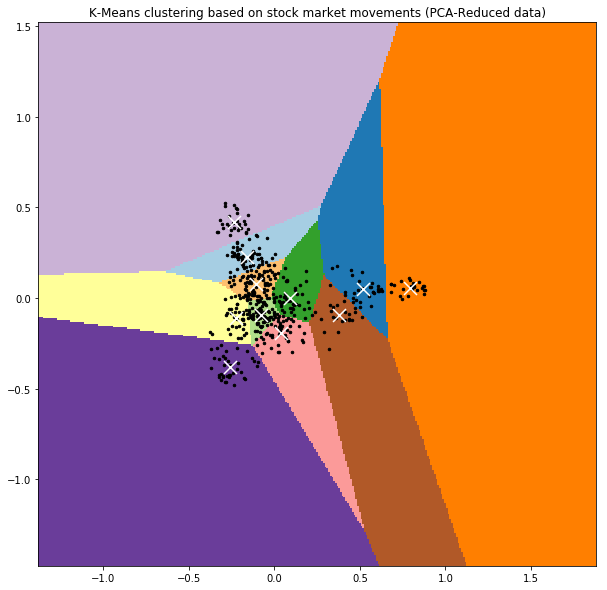

In [119]:
from sklearn.decomposition import PCA

# Reduce the data
reduced_data = PCA(n_components = 2).fit_transform(norm_movements)

# Define step size of mesh
h = 0.01

# Plot the decision boundary
x_min,x_max = reduced_data[:,0].min()-1, reduced_data[:,0].max() + 1
y_min,y_max = reduced_data[:,1].min()-1, reduced_data[:,1].max() + 1
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

# Obtain labels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(),yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Define color plot
cmap = plt.cm.Paired

# Plotting figure
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(Z,interpolation = 'nearest',extent=(xx.min(),xx.max(),yy.min(),yy.max()),cmap = cmap,aspect = 'auto',origin = 'lower')
plt.plot(reduced_data[:,0],reduced_data[:,1],'k.',markersize = 5)

# Plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1],marker = 'x',s = 169,linewidths = 3,color = 'w',zorder = 10)
plt.title('K-Means clustering based on stock market movements (PCA-Reduced data)')
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.show()

In [51]:
labels[0]

4

In [ ]:
labels[1]

In [ ]:
labels[2]

In [ ]:
labels[3]

In [ ]:
#########################################

### Question 1 Average Return for each cluster

In [ ]:
# Question 1 Average Return for each cluster

# cluster_performance = frame.groupby(['monthend_date',  'cluster', ]).agg({'total_return':'mean', 'ticker':'count' })
# cluster_performance.rename(columns = {'total_return':'avg_return'})

### Question 2

### Which ticker is in each cluster

In [ ]:
# # Extract each ticker and sector in each cluster
# flag=True

# for i in range(0,7):
   
#     cluster_group = frame.loc[frame["cluster"] ==i]["ticker"]

#     cluster_sector = frame.loc[frame["cluster"] ==i]["sector"]
   
#     cluster_tickergroup=pd.concat([cluster_group, cluster_sector], axis=1)
#     cluster_tickergroup["cluster"]=i
#     if flag==True:
#         clusterlist=cluster_tickergroup
#         flag=False
#     else:
#         clusterlist=pd.concat([clusterlist, cluster_tickergroup])
# clusterlist=clusterlist.set_index("cluster")
# clusterlist.head()

### Question 3 
#### Enter a ticker to find the cluster it belong to and check if it changes it cluster over time.

In [ ]:
# Enter a ticker to find the cluster it belong
ticker_request = (input("Enter the ticker to find a cluster it belong?:").upper())
ticker_request 

In [ ]:
# Print cluster information
#frame.loc[frame['ticker'] == ticker_request, ['monthend_date', 'ticker','cluster', 'total_return', 'sector']]

In [ ]:
# It looks like the ticker changes cluster in some years

In [ ]:
#===========================================================================================================================